In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import sklearn
import random
import math

In [2]:
"""
Disclaimer - I used code from my prelab03 submission to evaluate what the best canny edge thresholds would be for each of the images.
             the biggest issue was finding thresholds for parliament clock where the integrity of the circle edges were maintained but
             the rest of the noise did not influence the overall voting sequence in RANSAC. I hope this demonstrates my understanding
             of the course content and aids in the review of my code and overall marking.
             Cheers!
"""

'\nDisclaimer - I used code from my prelab03 submission to evaluate what the best canny edge thresholds would be for each of the images.\n             the biggest issue was finding thresholds for parliament clock where the integrity of the circle edges were maintained but\n             the rest of the noise did not influence the overall voting sequence in RANSAC. I hope this demonstrates my understanding\n             of the course content and aids in the review of my code and overall marking.\n             Cheers!\n'

In [3]:
circle_img = cv2.imread("circle.jpg")
concentric_circles_img = cv2.imread("concentric_circles.jpg")
parliament_clock_img = cv2.imread("parliament_clock.jpg") # initializing all the image variables

In [4]:
def CannyConvert(img, low, high): # converting all images to a canny image and recording their dimensions, output and edge pixel location to be used in future functions
    edges = []
    img_blurred = cv2.GaussianBlur(img, (3,3), cv2.BORDER_DEFAULT) # border_type is set to deafault borders of image
    img_gray = cv2.cvtColor(img_blurred, cv2.COLOR_BGR2GRAY)
    temp_image = cv2.Canny(img_gray, low, high) # applying .Canny() edge detection to image with a 3x3 kernel
    img_height, img_width = temp_image.shape
    for col in range(img_width):
        for row in range(img_height):
            if temp_image[row, col] == 255:
                edges.append((row, col)) # if pixels in the canny output are white they are edges --> append
    return img_height, img_width, edges 

def findThreePoints(edges):
    while True:
        point_1 = random.choice(edges)
        point_2 = random.choice(edges)
        point_3 = random.choice(edges) # checking if points form a triangle using shoelace formula
        if abs((point_1[0]*(point_2[1] - point_3[1])) + (point_2[0]*(point_3[1] - point_1[1])) + (point_3[0]*(point_1[1] - point_2[1]))) != 0: # keep checking until points are not colinear
            break
    return point_1, point_2, point_3

# Hough Algebraic Transform --> a(x**2+y**2) + bx + cy + d = 0
def HoughTransform(edges):
    p1, p2, p3 = findThreePoints(edges) # find 3 non-colinear points
    a = p1[1]*(p2[0] - p3[0]) - p1[0]*(p2[1]-p3[1]) + p2[1]*p3[0] - p3[1]*p2[0]
    
    b = (p1[1]**2 + p1[0]**2)*(p3[0] - p2[0]) + (p2[1]**2 + p2[0]**2)*(p1[0] - p3[0]) + (p3[1]**2 + p3[0]**2)*(p2[0] - p1[0])
    
    c = (p1[1]**2 + p1[0]**2)*(p2[1] - p3[1]) + (p2[1]**2 + p2[0]**2)*(p3[1] - p1[1]) + (p3[1]**2 + p3[0]**2)*(p1[1] - p2[1])
    
    d = (p1[1]**2 + p1[0]**2)*(p3[1]*p2[0] - p2[1]*p3[0]) + (p2[1]**2 + p2[0]**2)*(p1[1]*p3[0] - p3[1]*p1[0]) + (p3[1]**2 + p3[0]**2)*(p2[1]*p1[0] - p1[1]*p2[0])
    # perform abcd calculations to the 3 points
    try:
         x = int(-(b/(2*a)))
    except ZeroDivisionError:
         x = 0
    try:
         y = int(-(c/(2*a)))
    except ZeroDivisionError: # try and except blocks to catch division by 0 or inf
        y = 0
    try:
        r = int(math.sqrt((b**2 + c**2 - 4*a*d)/(4*(a**2))))
    except ZeroDivisionError:
        r = 0
    # print(r)
    return x, y, r

def drawCircle(img, x, y, r):
    img = cv2.circle(img, (x, y), r, (0,0,255), 2) # function to add circle to existing image based on r/x/y
    return img

def RANSAC(edges): # based on the edges of an image perform the RANSAC algorithm to vote to find best fit circle
    I = 0
    N = 10000
    C = -1
    best_circle = []
    inliners = []
    while I < N:
        K = 0
        temp_inliners = []
        x, y, r = HoughTransform(edges)
        for i in range(len(edges)): # using equation of circle (x-a)^2 + (y-b)^2 = r^2 with high and low r to determine if within threshold
            if ((r-1)**2 <= (((edges[i][1] - x)**2) + ((edges[i][0] - y)**2)) <= (r+1)**2):
                K += 1
                temp_inliners.append((edges[i][0], edges[i][1]))
        if K > C:
            best_circle = [x, y, r]
            C = K
            inliners = temp_inliners
            print("Circle Has Been Updated - with {} inliners, Iteration {}".format(C, I))
        I += 1
    return inliners, best_circle

In [5]:
def postProcessing(inliner_list, best_RANSAC_circle, edges):
    total_x = 0
    total_y = 0
    center_x = 0
    center_y = 0
    total_r = 0
    center_r = 0
    new_best_circle = []
    new_center_vote = 0
    old_center_vote = 0
    for i in range(len(inliner_list)):
        total_x += inliner_list[i][1]
        total_y += inliner_list[i][0]
    center_x = int(total_x/len(inliner_list))
    center_y = int(total_y/len(inliner_list)) # find center of x/y valyes
    
    for j in range(len(inliner_list)):
        total_r += math.sqrt(((inliner_list[j][0] - center_x)**2) + (inliner_list[j][1] - center_y)**2) # r^2 = (x-a)^2 + (y-b)^2
    center_r = int(total_r/len(inliner_list))  # finding mean radius
     
    for i in range(len(edges)): # checking to see if new avg center and avg radius circle is closer to edges than RANSAC circle
        if abs((center_r**2)-(((edges[i][1] - center_x)**2) + ((edges[i][0] - center_y)**2))) < abs((best_RANSAC_circle[2]**2)-(((edges[i][1] - best_RANSAC_circle[0])**2) + ((edges[i][0] - best_RANSAC_circle[1])**2))):
            new_center_vote += 1
        else:
            old_center_vote += 1
    if new_center_vote > old_center_vote: # if the avg circle is closer than rewrite the RANSAC as the postprocessed circle
        new_best_circle = [center_x, center_y, best_RANSAC_circle[2]]
        print("Circle Has Been Updated in Post Processing")
    else:
        new_best_circle = [best_RANSAC_circle[0], best_RANSAC_circle[1], best_RANSAC_circle[2]]
        print("Circle Has Not Been Updated in Post Processing")  
        
    print("Post Process r: ", center_r, "Votes: ", new_center_vote)
    print("Best Circle r: ", best_circle[2], "Votes: ", old_center_vote)
    return new_best_circle

Circle Has Been Updated - with 1089 inliners, Iteration 0
Circle Has Been Updated - with 1925 inliners, Iteration 1
Circle Has Been Updated - with 2150 inliners, Iteration 7
Circle Has Been Updated - with 2152 inliners, Iteration 22
Circle Has Been Updated - with 2153 inliners, Iteration 71


Text(0.5, 1.0, 'RANSAC Circle')

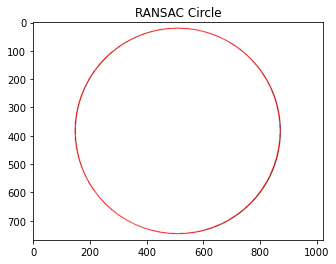

In [6]:
img_height, img_width, canny_edges = CannyConvert(circle_img, 100, 255) # using CannyTest.ipynb to check what thresholds are best for certain images to reduce noise

RANSAC_cpy = circle_img.copy()
all_inliners, best_circle = RANSAC(canny_edges) 
RANSAC_cpy = drawCircle(RANSAC_cpy, best_circle[0], best_circle[1], best_circle[2]) # RANSAC_cpy now contains original image with circle drawn over

plt.imshow(cv2.cvtColor(RANSAC_cpy, cv2.COLOR_BGR2RGB))
plt.title("RANSAC Circle")

Circle Has Not Been Updated in Post Processing
Post Process r:  382 Votes:  0
Best Circle r:  362 Votes:  5290


Text(0.5, 1.0, 'Post Processed Circle RANSAC')

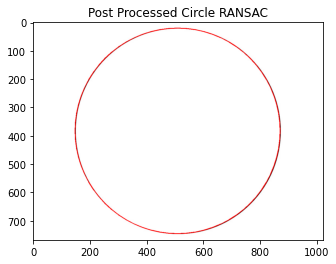

In [7]:
post_processed_copy = circle_img.copy()
post_processed_circle = postProcessing(all_inliners, best_circle, canny_edges)  # the inliners, RANSAC circle and edges of the image is passed into postProcessing function
post_processed_copy = drawCircle(post_processed_copy, post_processed_circle[0], post_processed_circle[1], post_processed_circle[2]) # orignial picture is returned with post processed function drawn on it

plt.imshow(cv2.cvtColor(post_processed_copy, cv2.COLOR_BGR2RGB))
plt.title("Post Processed Circle RANSAC")

Circle Has Been Updated - with 97 inliners, Iteration 0
Circle Has Been Updated - with 189 inliners, Iteration 2
Circle Has Been Updated - with 190 inliners, Iteration 3
Circle Has Been Updated - with 379 inliners, Iteration 11
Circle Has Been Updated - with 562 inliners, Iteration 79
Circle Has Been Updated - with 682 inliners, Iteration 518
Circle Has Been Updated - with 1014 inliners, Iteration 616


Text(0.5, 1.0, 'RANSAC Concentric Circles')

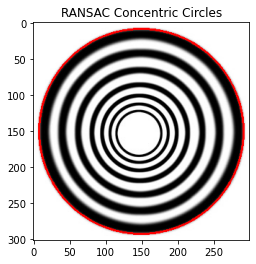

In [8]:
img_height, img_width, canny_edges = CannyConvert(concentric_circles_img, 100, 255)

RANSAC_cpy = concentric_circles_img.copy()
all_inliners, best_circle = RANSAC(canny_edges)
RANSAC_cpy = drawCircle(RANSAC_cpy, best_circle[0], best_circle[1], best_circle[2])

plt.imshow(cv2.cvtColor(RANSAC_cpy, cv2.COLOR_BGR2RGB))
plt.title("RANSAC Concentric Circles")

Circle Has Not Been Updated in Post Processing
Post Process r:  142 Votes:  3421
Best Circle r:  142 Votes:  4231


Text(0.5, 1.0, 'Post Processed Concentric Circle RANSAC')

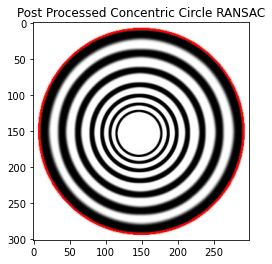

In [9]:
post_processed_copy = concentric_circles_img.copy()
post_processed_circle = postProcessing(all_inliners, best_circle, canny_edges)
post_processed_copy = drawCircle(post_processed_copy, post_processed_circle[0], post_processed_circle[1], post_processed_circle[2])

plt.imshow(cv2.cvtColor(post_processed_copy, cv2.COLOR_BGR2RGB))
plt.title("Post Processed Concentric Circle RANSAC")

Circle Has Been Updated - with 29 inliners, Iteration 0
Circle Has Been Updated - with 37 inliners, Iteration 2
Circle Has Been Updated - with 72 inliners, Iteration 3
Circle Has Been Updated - with 83 inliners, Iteration 45
Circle Has Been Updated - with 107 inliners, Iteration 156
Circle Has Been Updated - with 118 inliners, Iteration 591
Circle Has Been Updated - with 122 inliners, Iteration 629
Circle Has Been Updated - with 130 inliners, Iteration 1039
Circle Has Been Updated - with 132 inliners, Iteration 3409


Text(0.5, 1.0, 'RANSAC Parliament Circle')

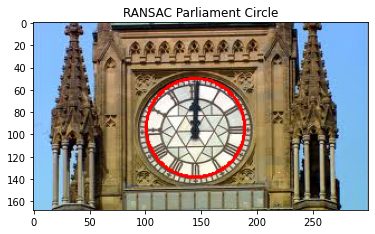

In [10]:
img_height, img_width, canny_edges = CannyConvert(parliament_clock_img, 350, 400) #250, 250 --> 400 500

RANSAC_cpy = parliament_clock_img.copy()
all_inliners, best_circle = RANSAC(canny_edges)
RANSAC_cpy = drawCircle(RANSAC_cpy, best_circle[0], best_circle[1], best_circle[2])

plt.imshow(cv2.cvtColor(RANSAC_cpy, cv2.COLOR_BGR2RGB))
plt.title("RANSAC Parliament Circle")

Circle Has Not Been Updated in Post Processing
Post Process r:  72 Votes:  853
Best Circle r:  44 Votes:  935


Text(0.5, 1.0, 'Post Processed Parliament Clock RANSAC')

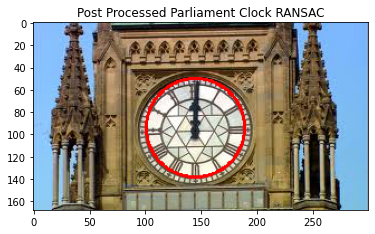

In [11]:
post_processed_copy = parliament_clock_img.copy()
post_processed_circle = postProcessing(all_inliners, best_circle, canny_edges)
post_processed_copy = drawCircle(post_processed_copy, post_processed_circle[0], post_processed_circle[1], post_processed_circle[2])

plt.imshow(cv2.cvtColor(post_processed_copy, cv2.COLOR_BGR2RGB))
plt.title("Post Processed Parliament Clock RANSAC")